!!! Программа делает все те же пункты, что в PostgreSQL. Но теперь решение через Pandas !!!

Задачи работы:

1. Топ-5 самых дорогих категорий, название самого прибыльного товара в каждой этой категории. Построение графика
2. Средний рейтинг и количество продаж в категории "Books", самая большая цена за книгу
3. Самая многочисленная группа в категории "Electronics". Количество и средняя стоимость этого товара, где рейтинг больше 2.1
4. Топ-3 самых прибыльных месяца в категории "Clothing" в 2023 году. Самый прибыльный товар месяца, количество его продаж, название города. Построение графика
5. Сравнение категории "Bath and body", "Skin care" и "Makeup" по средним параметрам: цена, рейтинг, продажи, выручка
6. Корелляция цены, рейтинга, скидки и продаж в категории "Blankets"
7. Топ-5 товаров по продажам
8. Средний рейтинг и продажи по категориям
9. Вина с высокой ценой, но низкими продажами (потенциальные кандидаты на скидку)
10. Есть ли товары с высоким рейтингом, но низкими продажами, или наоборот?
11. Выводы работы

Пояснения к таблице:

ProductID -> ID товара

ProductName -> Название товара

Category -> Категория товара

Price -> Цена товара

Rating -> Цена товара

NumReviews -> Количество отзывов на товар

StockQuantity -> Количество товара на складе

Discount -> Скидка на товар

Sales -> Количество продаж товара

DataAdded -> Дата добавления товара на склад

City -> Город

In [4]:
import pandas as pd
ecommerce = pd.read_csv(r"C:\Dima\Резюме-программы\Kaggle\ecommerce_product_dataset.csv", 
                        index_col = 'ProductID', parse_dates = ['DateAdded'], dtype = {'ProductID': int})
ecommerce.head()

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City
ProductID,,,,,,,,,,
1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-10,Albuquerque
2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-28,Queens
3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-20,Austin
4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-05,Dallas
5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-10,Tucson


1. Топ-5 самых дорогих категорий, название самого прибыльного товара в каждой этой категории. Построение графика

In [6]:
# Вычисление стоимости товара с учётом скидки для каждого товара
cost = round(ecommerce['Price'] * ecommerce['Discount'] * ecommerce['Sales'], 2)
ecommerce['Cost'] = cost

top_categories = ecommerce.groupby('Category')
top_categories = top_categories['Cost'].sum().sort_values(ascending = False).head()
# Топ-5 самых дорогих категорий
top_categories

Category
Bedsheets    3393200.31
Socks        3335210.09
Nail care    3319950.03
Skin care    3113934.45
Cookware     3094091.00
Name: Cost, dtype: float64

In [7]:
top_products_list = []
# Название самого прибыльного товара в каждой этой категории
for category in top_categories.keys():
    top_product = ecommerce[ecommerce['Category'] == category] \
        .sort_values('Cost', ascending=False) \
        .head(1)
    
    top_products_list.append({
        'Category': category,
        'ProductName': top_product['ProductName'].values[0],
        'Cost': top_product['Cost'].values[0]
    })

top_products_df = pd.DataFrame(top_products_list).set_index('Category')
top_products_df.sort_values('Cost', ascending = False, inplace = True)
top_products_df

,ProductName,Cost
Category,,
Socks,Wool Socks,444426.81
Cookware,Grill Pan,404264.15
Bedsheets,Silk Sheets,336297.82
Nail care,Nail Clippers,334597.37
Skin care,Cleanser,286112.81


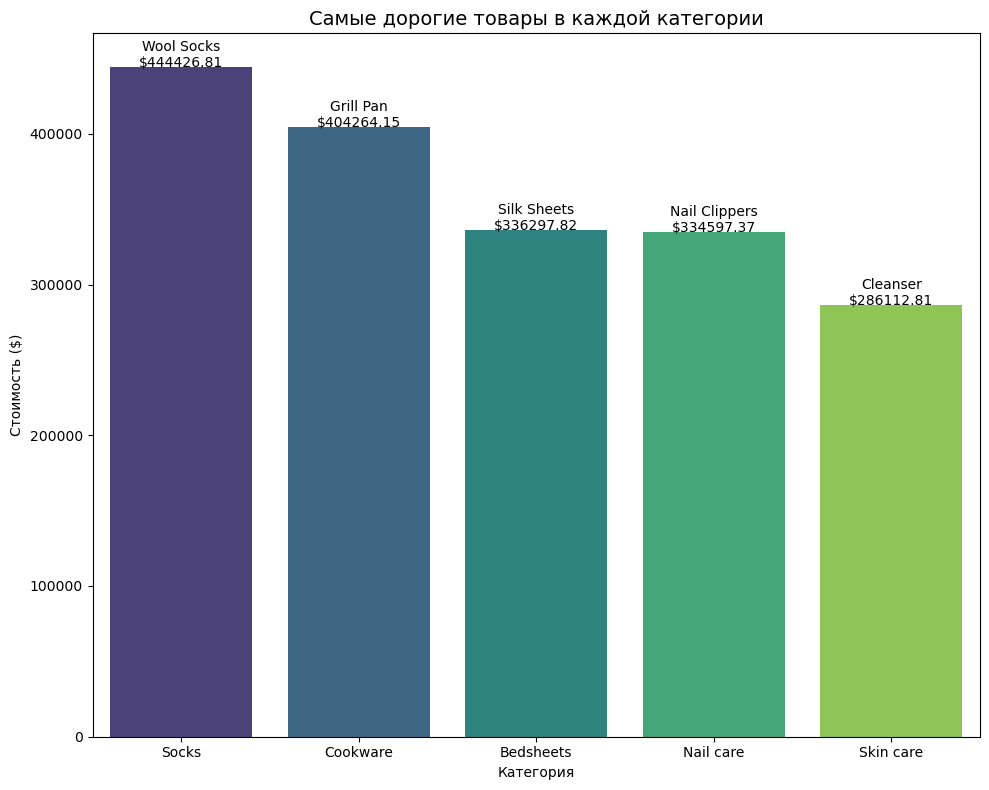

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

sns.barplot(
    data=top_products_df,
    x='Category',
    y='Cost',
    hue='ProductName',
    palette='viridis',
    dodge=False,
    legend=False
)

for index, row in top_products_df.iterrows():
    plt.text(
        x=index,
        y=row['Cost'] + 5,
        s=f"{row['ProductName']}\n${row['Cost']}",
        ha='center',
        fontsize=10
    )

plt.title('Самые дорогие товары в каждой категории', fontsize=14)
plt.xlabel('Категория')
plt.ylabel('Стоимость ($)')
plt.tight_layout()
plt.show()

2. Средний рейтинг и количество продаж в категории "Books", самая большая цена за книгу

In [10]:
# Средний рейтинг и количество продаж в категории "Books"
round(ecommerce[ecommerce['Category'] == 'Books'][['Rating', 'Sales']].mean(), 2)

Rating       3.07
Sales     1030.38
dtype: float64

In [11]:
round(ecommerce[ecommerce['Category'] == 'Books'][['Rating', 'Sales']].median(), 2)

Rating       2.95
Sales     1137.00
dtype: float64

In [12]:
# Самая большая цена за книгу
ecommerce[ecommerce['Category'] == 'Books'][['ProductName', 'Price', 'Rating', 'Sales']].sort_values(['ProductName', 'Price'], ascending = [True, False]).head(1)

,ProductName,Price,Rating,Sales
ProductID,,,,
153,Biography,492.36,3.1,74


3. Самая многочисленная группа в категории "Electronics". Количество и средняя стоимость этого товара, где рейтинг больше 2.1

In [14]:
# Самая многочисленная группа в категории "Electronics". Количество
ecommerce[ecommerce['Category'] == 'Electronics']['ProductName'].value_counts().head(1)

ProductName
Headphones    13
Name: count, dtype: int64

In [15]:
# Средняя стоимость этого товара, где рейтинг больше 2.1
headphones = ecommerce[(ecommerce['ProductName'] == 'Headphones') & (ecommerce['Rating'] > 2.1)]
round(headphones[headphones['ProductName'] == 'Headphones']['Price'].mean(), 2)

247.94

4. Топ-3 самых прибыльных товара в категории "Clothing" в 2023 году. Самый прибыльный месяц, количество продаж этого месяца. Построение графика

In [17]:
top_clothing = ecommerce[(ecommerce['Category'] == 'Clothing') & (ecommerce['DateAdded'].dt.year == 2023)].copy()
top_clothing = top_clothing.groupby('ProductName')
top_clothing = top_clothing['Cost'].sum().sort_values(ascending = False).head(3)
# Топ-5 самых дорогих категорий
top_clothing

ProductName
T-Shirt    442079.10
Jeans      236122.16
Jacket     172697.67
Name: Cost, dtype: float64

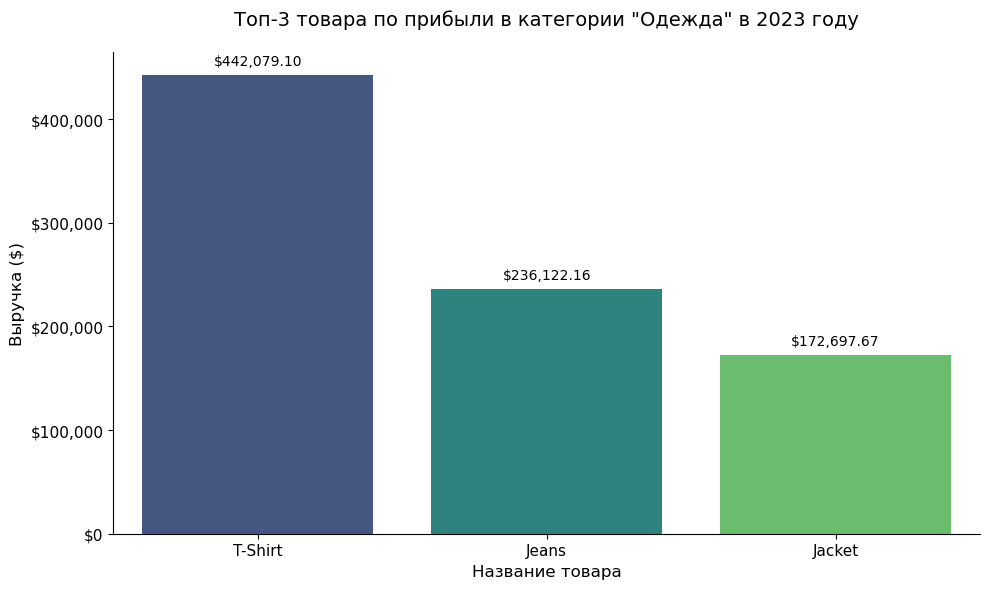

In [18]:
df_top = pd.DataFrame(list(top_clothing.items()), columns=['Product', 'Revenue'])

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_top,
    x='Product',
    y='Revenue',
    palette='viridis',
    hue='Product',
    dodge=False,
    legend=False
)

for p in barplot.patches:
    barplot.annotate(
        f'${p.get_height():,.2f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points',
        fontsize=10
    )

plt.title('Топ-3 товара по прибыли в категории "Одежда" в 2023 году', fontsize=14, pad=20)
plt.xlabel('Название товара', fontsize=12)
plt.ylabel('Выручка ($)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine()

plt.gca().yaxis.set_major_formatter('${x:,.0f}')

plt.tight_layout()
plt.show()

In [19]:
# Самый прибыльный месяц, количество продаж этого месяца
clothing = ecommerce[(ecommerce['Category'] == 'Clothing') & (ecommerce['DateAdded'].dt.year == 2023)].copy()
clothing['Month'] = clothing['DateAdded'].dt.month

result = {}
for month in clothing['Month'].unique():
    key = clothing['Month'] == month
    result[month] = round(sum(clothing[key]['Cost']), 2)

top_month = dict(sorted(result.items(), key=lambda item: item[1], reverse=True)[:1])
top_month

{12: 202602.79}

5. Сравнение категории "Bath and body", "Skin care" и "Makeup" по средним параметрам: цена, рейтинг, скидка, продажи, выручка

In [21]:
bath_and_body = round(ecommerce[ecommerce['Category'] == 'Bath and body'][['Price','Rating', 'Discount', 'Sales', 'Cost']].mean(), 2)
skin_care = round(ecommerce[ecommerce['Category'] == 'Skin care'][['Price','Rating', 'Discount', 'Sales', 'Cost']].mean(), 2)
makeup = round(ecommerce[ecommerce['Category'] == 'Makeup'][['Price','Rating', 'Discount', 'Sales', 'Cost']].mean(), 2)
data = {
    "Bath_and_body": pd.Series(bath_and_body),
    "Skin_care": pd.Series(skin_care),
    "Makeup": pd.Series(makeup)
}
data = pd.DataFrame(data)
data

,Bath_and_body,Skin_care,Makeup
Price,238.13,282.07,259.44
Rating,2.95,2.93,2.76
Discount,0.21,0.26,0.28
Sales,1061.35,1022.22,1058.42
Cost,55076.09,77848.36,72733.78


In [22]:
max_series = data.idxmax(axis=1)
max_values = data.max(axis=1)

min_series = data.idxmin(axis=1)
min_values = data.min(axis=1)

result = pd.DataFrame({
    "Max Series": max_series,
    "Max Value": max_values,
    "Min Series": min_series,
    "Min Value": min_values
})
# Максимальное значение и соответствующая ему серия товара. То же самое с минимальными значениями
result

,Max Series,Max Value,Min Series,Min Value
Price,Skin_care,282.07,Bath_and_body,238.13
Rating,Bath_and_body,2.95,Makeup,2.76
Discount,Makeup,0.28,Bath_and_body,0.21
Sales,Bath_and_body,1061.35,Skin_care,1022.22
Cost,Skin_care,77848.36,Bath_and_body,55076.09


6. Корелляция цены, рейтинга, скидки и продаж в категории "Blankets"

In [24]:
ecommerce[ecommerce['Category'] == 'Blankets'][['Price', 'Rating', 'Discount', 'Sales']].corr()

,Price,Rating,Discount,Sales
Price,1.000000,0.044312,-0.204267,-0.145094
Rating,0.044312,1.000000,-0.142535,-0.283387
Discount,-0.204267,-0.142535,1.000000,-0.114258
Sales,-0.145094,-0.283387,-0.114258,1.000000


7. Топ-5 товаров по продажам

In [26]:
ecommerce.nlargest(5, 'Sales')[['ProductName', 'Sales']]

,ProductName,Sales
ProductID,,
944,Screen Protector,1997
431,Sketchbook,1995
625,Silk Sheets,1991
932,Earbuds,1984
615,Linen Sheets,1983


8. Средний рейтинг и продажи по категориям

In [28]:
round(ecommerce.groupby('Category')[['Rating', 'Sales']].mean().sort_values('Sales', ascending=False), 2)

,Rating,Sales
Category,,
Bedsheets,3.03,1165.78
Art and crafting materials,2.96,1147.80
Motor vehicle parts,2.88,1127.90
Vitamins and supplements,2.98,1110.05
Mobile phone accessories,2.82,1091.50
Electronics,2.85,1071.10
Bicycles,3.00,1068.75
Bath and body,2.95,1061.35
Makeup,2.76,1058.42


9. Вина с высокой ценой, но низкими продажами (потенциальные кандидаты на скидку)

In [30]:
wine = ecommerce[ecommerce['Category'] == 'Wine']
wine[(wine['Price'] > wine['Price'].quantile(0.75)) & (wine['Sales'] < wine['Sales'].median())]

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City,Cost
ProductID,,,,,,,,,,,
530,Sparkling Wine,Wine,432.86,3.1,3089,605,0.08,288,2023-11-16,Omaha,9973.09
539,Sparkling Wine,Wine,351.66,4.0,504,597,0.42,498,2023-06-14,Spokane,73553.21
544,Sparkling Wine,Wine,471.85,1.2,2370,850,0.04,205,2023-07-28,Rochester,3869.17
548,Rose Wine,Wine,341.96,4.0,3426,484,0.10,43,2024-05-14,Sacramento,1470.43
552,Sparkling Wine,Wine,303.89,4.4,2781,715,0.36,394,2023-11-18,Port St. Lucie,43103.76


10. Есть ли товары с высоким рейтингом, но низкими продажами, или наоборот?

In [32]:
# Максимальный рейтинг = 5
high_rating = ecommerce[(ecommerce['Rating'] > 4) & (ecommerce['Sales'] < 500)][['ProductName', 'Sales']]
high_rating.groupby('ProductName').sum('Sales')
# Выводит суммарные продажи за одинаковые товары, так что Sales на выходе может быть > 500

,Sales
ProductName,
Ankle Socks,573
Art Print,71
Beeswax Candle,475
Blender,68
Board Game,335
Body Scrub,597
Body Spray,378
Boxers,314
Briefs,315


In [33]:
# Есть ли товары с низким рейтингом, но высокими продажами
high_rating = ecommerce[(ecommerce['Rating'] < 2) & (ecommerce['Sales'] > 1000)][['ProductName', 'Sales']]
high_rating.groupby('ProductName').sum('Sales')

,Sales
ProductName,
Bath Salts,1634
Beeswax Candle,3713
Biography,6277
Blender,3509
Blush,2911
...,...
Vitamin D,3428
Water Bottle,1324
Weighted Blanket,1962


11. Выводы работы (то же самое, что и в файле с PostgreSQL)

1. Мы узнали 5 самых прибыльных товаров (Silk Sheets, Wool Socks, Nail Clippers, Cleanser, Grill Pan). Их развитие (новые материалы, цвета, состав) может увеличить ассортимент категории, привлечь новых клиентов, увеличить выручку.

2. Рейтинг самой дорогой книги равен 3.1, в то время, пока средний рейтинг абсолютно всех книг равен 3.07, а медианный - 2.95. Это говорит о том, что существуют книги, чей рейтинг выше 3.1, но чья цена меньше, чем у книги с рейтингом 3.1. Следовательно, нет гарантии, что, чем выше рейтинг книги, тем дороже она стоит. Также известно, что количество продаж книги (74) значительно меньше, чем средние продажи книг (1030). Если на книгу маленький спрос (как в этом случае), то цена должна быть маленькой. В нашем случае всё наоборот. Стоит снизить цену или провести исследование: возможно, книга — редкое коллекционное издание, и цена оправдана.

3. Самый прибыльный месяц в категории "Одежда" стал Декабрь. Скорее всего, причиной тому являются предстоящие новогодние праздники, покупки себе и знакомым. И в число таких покупок входит и одежда. В таком случае стоит увеличить запасы зимних товаров к ноябрю и запустить предпраздничные акции.

4. В девятом пункте были взяты все вИна, чья цена входит в топ-25%, но чьи продажи меньше медианы. Такое сочетание говорит о том, что увеличение скидки потенциально может повысить продажи данных вин. При увеличении скидки нужно учитывать, что выручка с одной бутылки уменьшится, но за счёт сниженной цены больше человек сможет себе позволить купить такое вино, что увеличит суммарную выручку. Но, если скидка не приведёт к росту спроса, то выручка упадёт. Поэтому с принятием об увеличении скидки нужно вести себя осторожно. Также, помимо увеличения скидки, есть вариант провести маркетинговую кампанию (что тоже потребует дополнительных затрат).

5. В последнем пункте мы нашли товары с большим рейтингом, но маленькими продажами. Такое соотношение означает, что товары качетсвенные, но далее нужно выяснить, в чём причина маленьких продаж: либо маленький спрос, либо плохой маркетинг, либо цена для такого товара слишком завышена. Следует рассмотреть все эти факторы, сравнить их с конкурентами и общим состоянием рынка для этих товаров.

    Также мы нашли товары с маленьким рейтингом, но большими продажами. Такое соотношение говорит о том, что спрос на товар большой независимо от качества.